## Prophetをoptunaでパラメータチューニングを行う

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
from matplotlib import pylab as plt

%matplotlib inline

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import warnings

warnings.filterwarnings("ignore")

In [3]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv("../../data/AirPassengers.csv")

# float型に変換
df["#Passengers"] = df["#Passengers"].astype("float64")
df = df.rename(columns={"#Passengers": "Passengers"})

# datetime型に変換にする
df.Month = pd.to_datetime(df.Month)

# データの中身を確認
df.head()

,Month,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


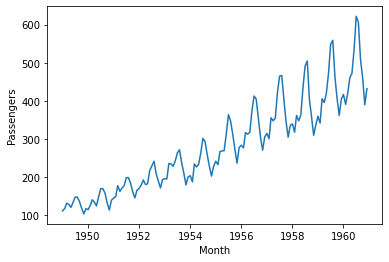

In [4]:
fig, ax = plt.subplots()
a = sns.lineplot(x="Month", y="Passengers", data=df)
plt.show()

## Prophetでモデルを構築する
- optunaでハイパラチューニングを行う

In [5]:
def objective_variable(train, valid):
    def objective(trial):
        params = {
            "changepoint_range": trial.suggest_discrete_uniform(
                "changepoint_range", 0.8, 0.95, 0.001
            ),
            "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
            "changepoint_prior_scale": trial.suggest_discrete_uniform(
                "changepoint_prior_scale", 0.001, 0.5, 0.001
            ),
            "seasonality_prior_scale": trial.suggest_discrete_uniform(
                "seasonality_prior_scale", 1, 25, 0.1
            ),
        }

        # fit_model
        model = Prophet(
            changepoint_range=params["changepoint_prior_scale"],
            n_changepoints=params["n_changepoints"],
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
        )

        model.fit(train)
        future = model.make_future_dataframe(periods=len(valid))

        forecast = model.predict(future)
        valid_forecast = forecast.tail(len(valid))

        val_mape = np.mean(np.abs((valid_forecast.yhat - valid.y) / valid.y)) * 100

        return val_mape

    return objective


def optuna_parameter(train, valid):
    study = optuna.create_study(sampler=TPESampler(seed=10))
    study.optimize(objective_variable(train, valid), n_trials=50)
    optuna_best_params = study.best_params

    return study

In [6]:
%%time
df = df.rename(columns={'Month':'ds','Passengers':'y'})
df = df[['ds','y']]
df_train = df[df['ds'] < '1956-04-01']
df_valid = df[(df['ds'] >= '1956-04-01')&(df['ds'] < '1957-04-01')]
df_test = df[df['ds'] >= '1957-04-01']

study = optuna_parameter(df_train, df_valid)

[I 2021-07-24 06:17:59,307] A new study created in memory with name: no-name-dc11fd25-b83c-4e1d-b3d0-a7604a536dcf
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-07-24 06:18:05,741] Trial 0 finished with value: 9.967007943607571 and parameters: {'changepoint_range': 0.916, 'n_changepoints': 20, 'changepoint_prior_scale': 0.317, 'seasonality_prior_scale': 19.0}. Best is trial 0 with value: 9.967007943607571.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
[I 2021-07-24 06:18:08,733] Trial 1 finished with value: 10.15987919340569 and parameters: {'changepoint_range': 0.875, 'n_changepoints': 23,

CPU times: user 3min 55s, sys: 2.02 s, total: 3min 57s
Wall time: 3min 57s


In [7]:
# fit_model
best_model = Prophet(
    changepoint_range=study.best_params["changepoint_prior_scale"],
    n_changepoints=study.best_params["n_changepoints"],
    seasonality_prior_scale=study.best_params["seasonality_prior_scale"],
    changepoint_prior_scale=study.best_params["changepoint_prior_scale"],
)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


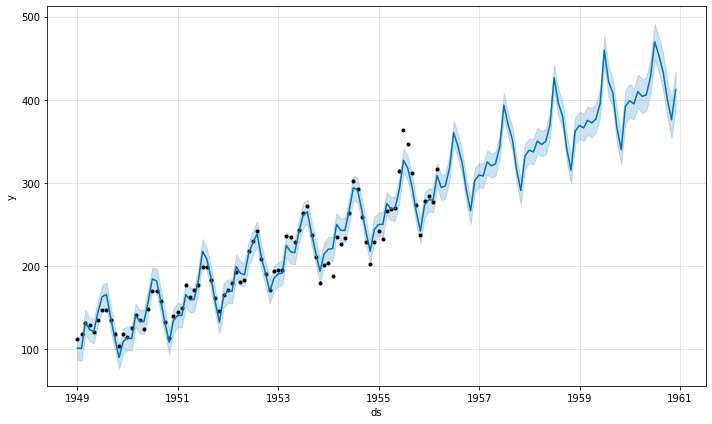

In [8]:
best_model.fit(df_train)
feature_test = best_model.make_future_dataframe(
    periods=len(df_valid) + len(df_test), freq="M"
)

forecast_test = best_model.predict(feature_test)
forecast_test_plot = best_model.plot(forecast_test)

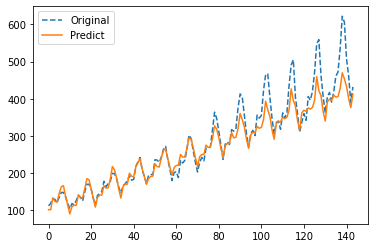

In [9]:
fig, ax = plt.subplots()
df.y.plot(ax=ax, label="Original", linestyle="dashed")
forecast_test.yhat.plot(ax=ax, label="Predict")
ax.legend()